In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

sys.path.append('../../../common_code')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


obtain index of the SFRD models that we want to highlight


In [3]:

def plotFormationChannelsPerMetallicitySingle(axe=[], metallicities=[0.001, 0.33], formationRates=[0,0], colorlist=['k'], totalcolor='k', BPSmodelname='A',Ylim=3.85, DCOtype='BBH'):
    
    
    # start building from 0
    upperY = np.zeros_like(formationRates[0])
    lowerY = np.zeros_like(formationRates[0])
    # go over rates of channels
    
    solar=0.0142

    total = 0 
    for ind_c, c_rate in enumerate(formationRates):
        total += c_rate 
    
    total_sum = np.sum(total)
    
    for ind_c, c_rate in enumerate(formationRates):
        
        # add this rate, 
        upperY += c_rate
        percentage = (np.sum(c_rate) / total_sum)*100.
#         if percentage<=0.5:
#             percentage_str = r'$<1$' + str(r'\%')
#         else:
        percentage_str =  r'$%s$'%str((roundAndFormat1(percentage))) + str(r'\%')
        
        # 1e5 to make the numbers nice 
        axe.fill_between(metallicities, lowerY*1e5, upperY*1e5, facecolor=colorlist[ind_c], \
                  lw=3, alpha=1, label=percentage_str)
        lowerY += c_rate
    

    text_list = [r'$Z_{\rm{i}}=Z_{\odot}$', r'$Z_{\rm{i}}=Z_{\odot}/2$', \
                 r'$Z_{\rm{i}}=Z_{\odot}/5$',  r'$Z_{\rm{i}}=Z_{\odot}/10$',\
                 r'$Z_{\rm{i}}=0.001$', r'$Z_{\rm{i}}=0.0105$']    
    for zz_ind, zz in enumerate([np.log10(solar), \
                                 np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.001),\
                                 np.log10(0.0105)]) :
        axe.plot([zz,zz], [0,Ylim+1], \
                         c='k',\
                         lw=1.2, alpha=1, linestyle=':', zorder=100)   
        axe.text(zz-0.06, Ylim-0.022, s=text_list[zz_ind], fontsize=fs-8.5, rotation=90, verticalalignment='top')   





        
    # location of the small legends is on the left, unless it does not fit:
    if DCOtype=='BBH':
        x_box, y_box = 0.63, .4
    elif (DCOtype=='BNS') and (BPSmodelname=='G'):
        x_box, y_box = 0.63, .4
    else:
        x_box, y_box = 0.02, .5
        
    axe.legend(fontsize=14,  ncol=2, \
               bbox_to_anchor=(x_box, y_box),loc="lower left", borderaxespad=0., frameon=False).set_zorder(10000)
   
    axe.set_xlim(min(metallicities), max(metallicities))
    axe.set_ylim(0,Ylim)
        
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelname) +'\n' + alphabetPhysicalNameDict[BPSmodelname], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    
    return axe
    
    

In [5]:

def plotGridFormationRatePerMetallicity(DCOtype = 'BBH', Ylim = 10, csvPath='None'):


    solar=0.0142


    channel_names = ['I_classic', 'II_only_stable_MT', 'III_single_core_CE', 'IV_double_core_CE', 'V_other']
    colorlist = [ '#118AB2', '#EF476F', '#FFD166', '#073B4C', 'gray']

    metallicities = [0.0001, 0.00011, 0.00012, 0.00014, 0.00016, 0.00017,\
   0.00019, 0.00022, 0.00024, 0.00027, 0.0003, 0.00034, \
   0.00037, 0.00042, 0.00047, 0.00052, 0.00058, 0.00065,\
   0.00073, 0.00081, 0.0009, 0.00101, 0.00113, 0.00126,\
   0.0014, 0.00157, 0.00175, 0.00195, 0.00218, 0.00243, \
   0.00272, 0.00303, 0.00339, 0.00378, 0.00422, 0.00471, \
   0.00526, 0.00587, 0.00655, 0.00732, 0.00817, 0.00912, \
   0.01018, 0.01137, 0.01269, 0.01416, 0.01581, 0.01765, 0.01971, 0.022, 0.0244, 0.02705, 0.03]



    dictDCOtypeDCOlabel = {'BBH':'BHBH', 'BNS':'NSNS', 'BHNS':'BHNS', 'NSBH':'NSBH'}
    print('doing DCO type  ', DCOtype)
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]  
    DCOname = dictDCOtypeDCOlabel[DCOtype]
    log10metallicities= np.log10(np.asarray(metallicities))



    ncols=3
    nrows=6
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(22,26), 
                  gridspec_kw={"width_ratios":1*np.ones(ncols), "height_ratios":1*np.ones(nrows)}) 



    
    for ind_m, bps_model in enumerate(BPSnameslist):
        print('now at model ', alphabetDirDict[bps_model])


        # hack to obtain the axis row and column index 
        ii = int(ind_m/ncols)%nrows
        jj = ind_m%ncols
  

        formationRates = []
        
#         df = pd.read_csv(csvPath+'formationRatesTotalAndPerChannel_'+DCOname+   '.csv', index_col=0)
        df = pd.read_csv(csvPath+'formationRatesTotalAndPerChannel_'+ DCOname +'_.csv', index_col=0)
        for ind_c, c_ in enumerate(channel_names):

            key_ = bps_model + ' ' + c_ + '  [Msun^{-1}]'

            # rate of this channel: 
            c_rate = df[key_]


            formationRates.append(c_rate)


        # plot for this sub panel & sub model the formation rate per metallicity 
        axe[ii,jj] = plotFormationChannelsPerMetallicitySingle(axe=axe[ii,jj],\
                                                             metallicities=log10metallicities,\
                                                             formationRates=formationRates, \
                                                               colorlist=colorlist, BPSmodelname=bps_model, Ylim=Ylim, DCOtype=DCOtype)


#         if (ii==0) and (jj==0):
    

        if (jj!=0):
            axe[ii,jj].set_yticks([])



    # fontsize of x and y labels
    fs_label = 20
    
    
    # set only xlabels for bottom panels 
    for jj in range(3):    
#         xlabel = r'$\log_{10}(Z_{\rm{i}}/\rm{Z}_{\odot})$'
        xlabel = r'$\log_{10}(Z_{\rm{i}})$'
        axe[4,jj] == layoutAxes(axe[4,jj], nameX=xlabel, fontsize=fs_label)

    # set only ylabels for most left panels 
    for ii in range(nrows):
#         for kk in [1,2]:
        ylabel = r'${\rm{d}} N_{\rm{form}} / \rm{d}M_{\rm{SFR}}  \ \  [10^{-5}\ \rm{M}_{\odot}^{-1}]\  $'
        axe[ii,0] == layoutAxes(axe[ii,0], nameX=xlabel, nameY=ylabel, fontsize=fs_label)
        
        
    
    # set only xlabels for bottom panels 
    for jj in range(3):    
#         xlabel = r'$\log_{10}(Z_{\rm{i}}/\rm{Z}_{\odot})$'
        xlabel = r'$\log_{10}(Z_{\rm{i}})$'
        axe[4,jj] == layoutAxes(axe[4,jj], nameX=xlabel, fontsize=fs_label)



    # set only ylabels for most left panels 
    for ii in range(nrows):
        ylabel = r'${\rm{d}} N_{\rm{form}} / \rm{d}M_{\rm{SFR}}  \ \  [10^{-5}\ \rm{M}_{\odot}^{-1}]\  $'
        axe[ii,0] == layoutAxes(axe[ii,0], nameX=xlabel, nameY=ylabel, fontsize=fs_label)



    plt.tight_layout() 
    plt.subplots_adjust(wspace=0., hspace=0.)
    plt.savefig('./FormationRatePerMetallicity_'+ DCOname +'.png', dpi=600)
    plt.savefig('./FormationRatePerMetallicity_'+ DCOname +'.pdf')
    plt.show()
    plt.close()
    

In [54]:
# df = pd.read_csv(csvPath+'formationRatesTotalAndPerChannel_'+'BHBH'+   '.csv', index_col=0)
# Zi = (df['Z_i'])
# rate = (df['A total  [Msun^{-1}]'])
# classic =  (df['A I_classic  [Msun^{-1}]'])


# plt.scatter(np.log10(Zi), rate)
# plt.scatter(np.log10(Zi), classic)
# # plt.yscale('log')
# plt.show()



# print(df)


doing DCO type   BBH
now at model  fiducial
now at model  massTransferEfficiencyFixed_0_25
now at model  massTransferEfficiencyFixed_0_5
now at model  massTransferEfficiencyFixed_0_75
now at model  unstableCaseBB
now at model  alpha0_5
now at model  alpha2_0
now at model  fiducial
now at model  rapid
now at model  maxNSmass2_0
now at model  maxNSmass3_0
now at model  noPISN
now at model  ccSNkick_100km_s
now at model  ccSNkick_30km_s
now at model  noBHkick
now at model  wolf_rayet_multiplier_0_1
now at model  wolf_rayet_multiplier_5


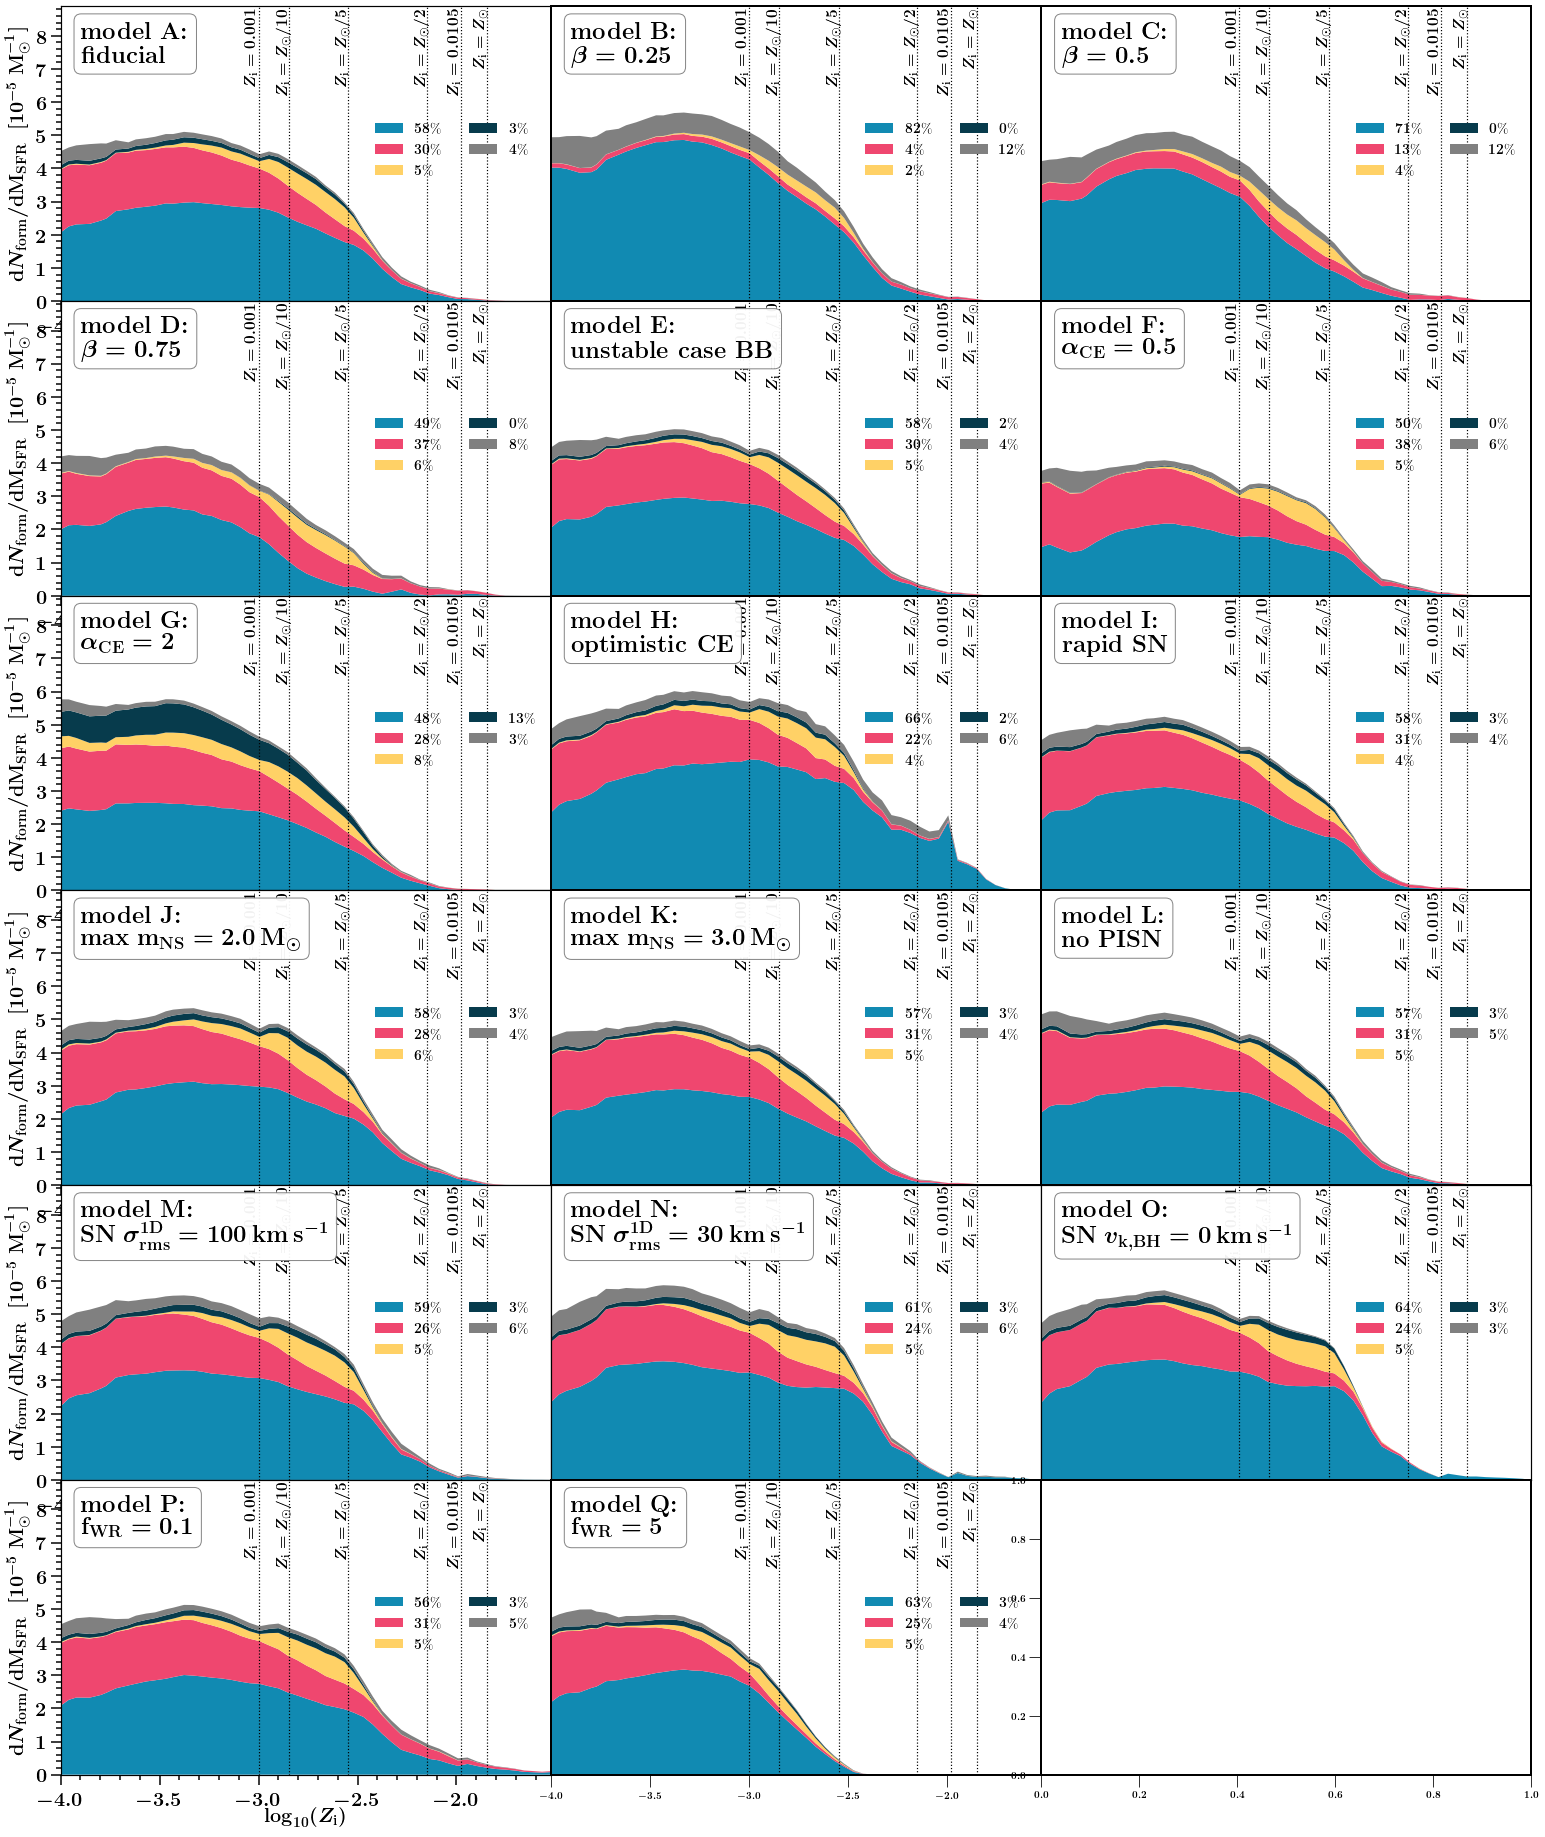

In [63]:
csvPath ='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_1/'    
plotGridFormationRatePerMetallicity(DCOtype = 'BBH', Ylim = 8.89, csvPath=csvPath)



doing DCO type   BHNS
now at model  fiducial
now at model  massTransferEfficiencyFixed_0_25
now at model  massTransferEfficiencyFixed_0_5
now at model  massTransferEfficiencyFixed_0_75
now at model  unstableCaseBB
now at model  alpha0_5
now at model  alpha2_0
now at model  fiducial
now at model  rapid
now at model  maxNSmass2_0
now at model  maxNSmass3_0
now at model  noPISN
now at model  ccSNkick_100km_s
now at model  ccSNkick_30km_s
now at model  noBHkick
now at model  wolf_rayet_multiplier_0_1
now at model  wolf_rayet_multiplier_5


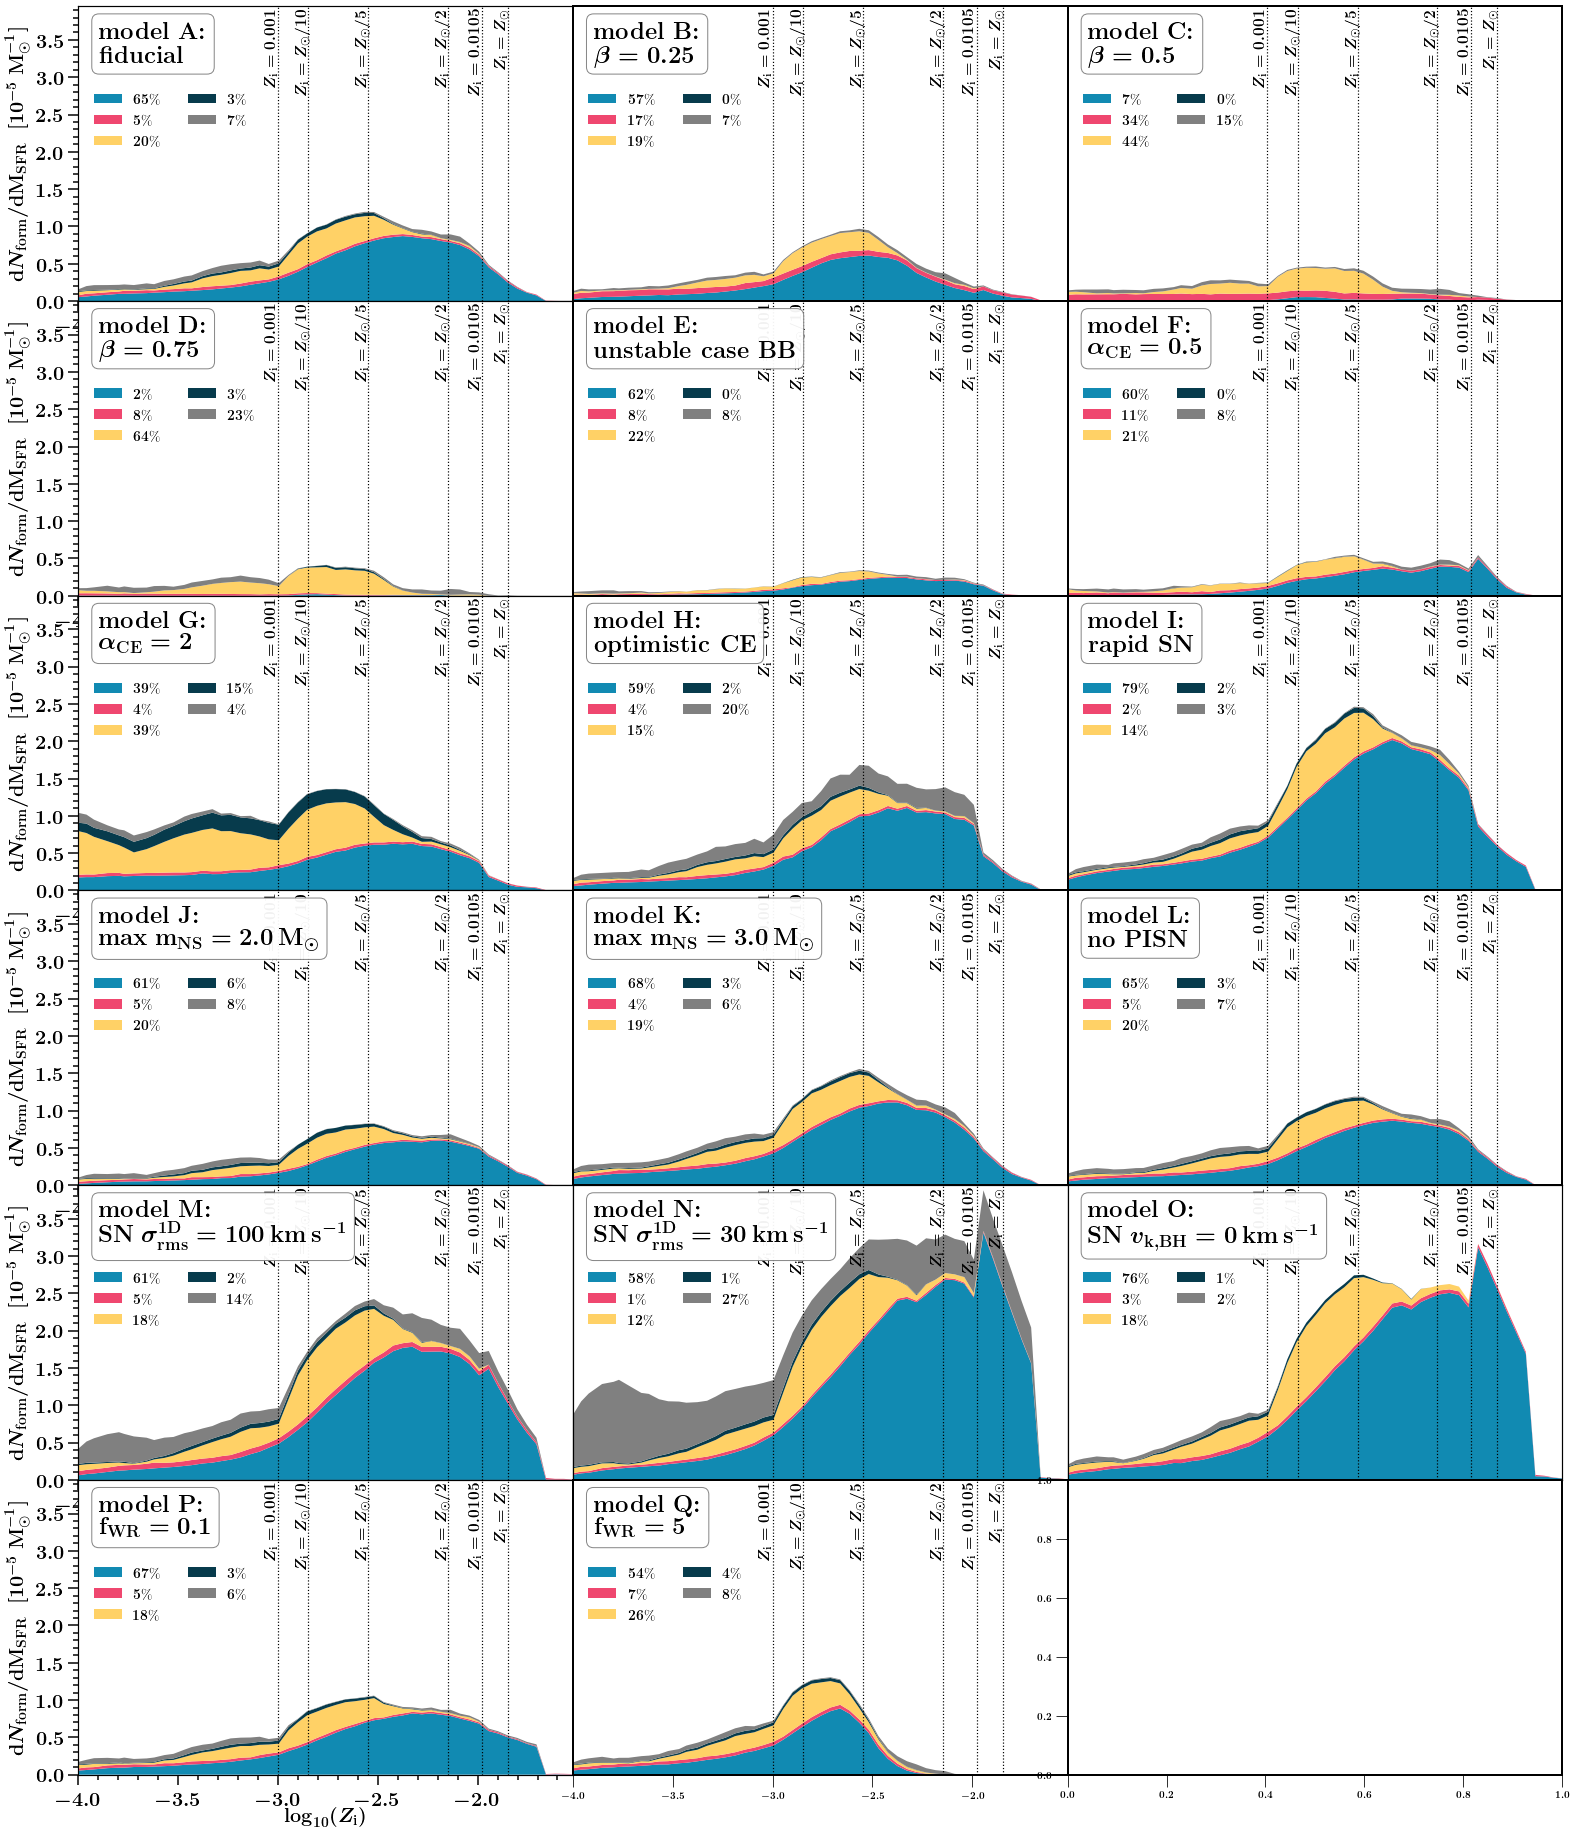

In [62]:
csvPath ='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_1/' 
plotGridFormationRatePerMetallicity(DCOtype = 'BHNS',Ylim = 3.95, csvPath=csvPath)



doing DCO type   BNS
now at model  fiducial
now at model  massTransferEfficiencyFixed_0_25
now at model  massTransferEfficiencyFixed_0_5
now at model  massTransferEfficiencyFixed_0_75
now at model  unstableCaseBB
now at model  alpha0_5
now at model  alpha2_0
now at model  fiducial
now at model  rapid
now at model  maxNSmass2_0
now at model  maxNSmass3_0
now at model  noPISN
now at model  ccSNkick_100km_s
now at model  ccSNkick_30km_s
now at model  noBHkick
now at model  wolf_rayet_multiplier_0_1
now at model  wolf_rayet_multiplier_5


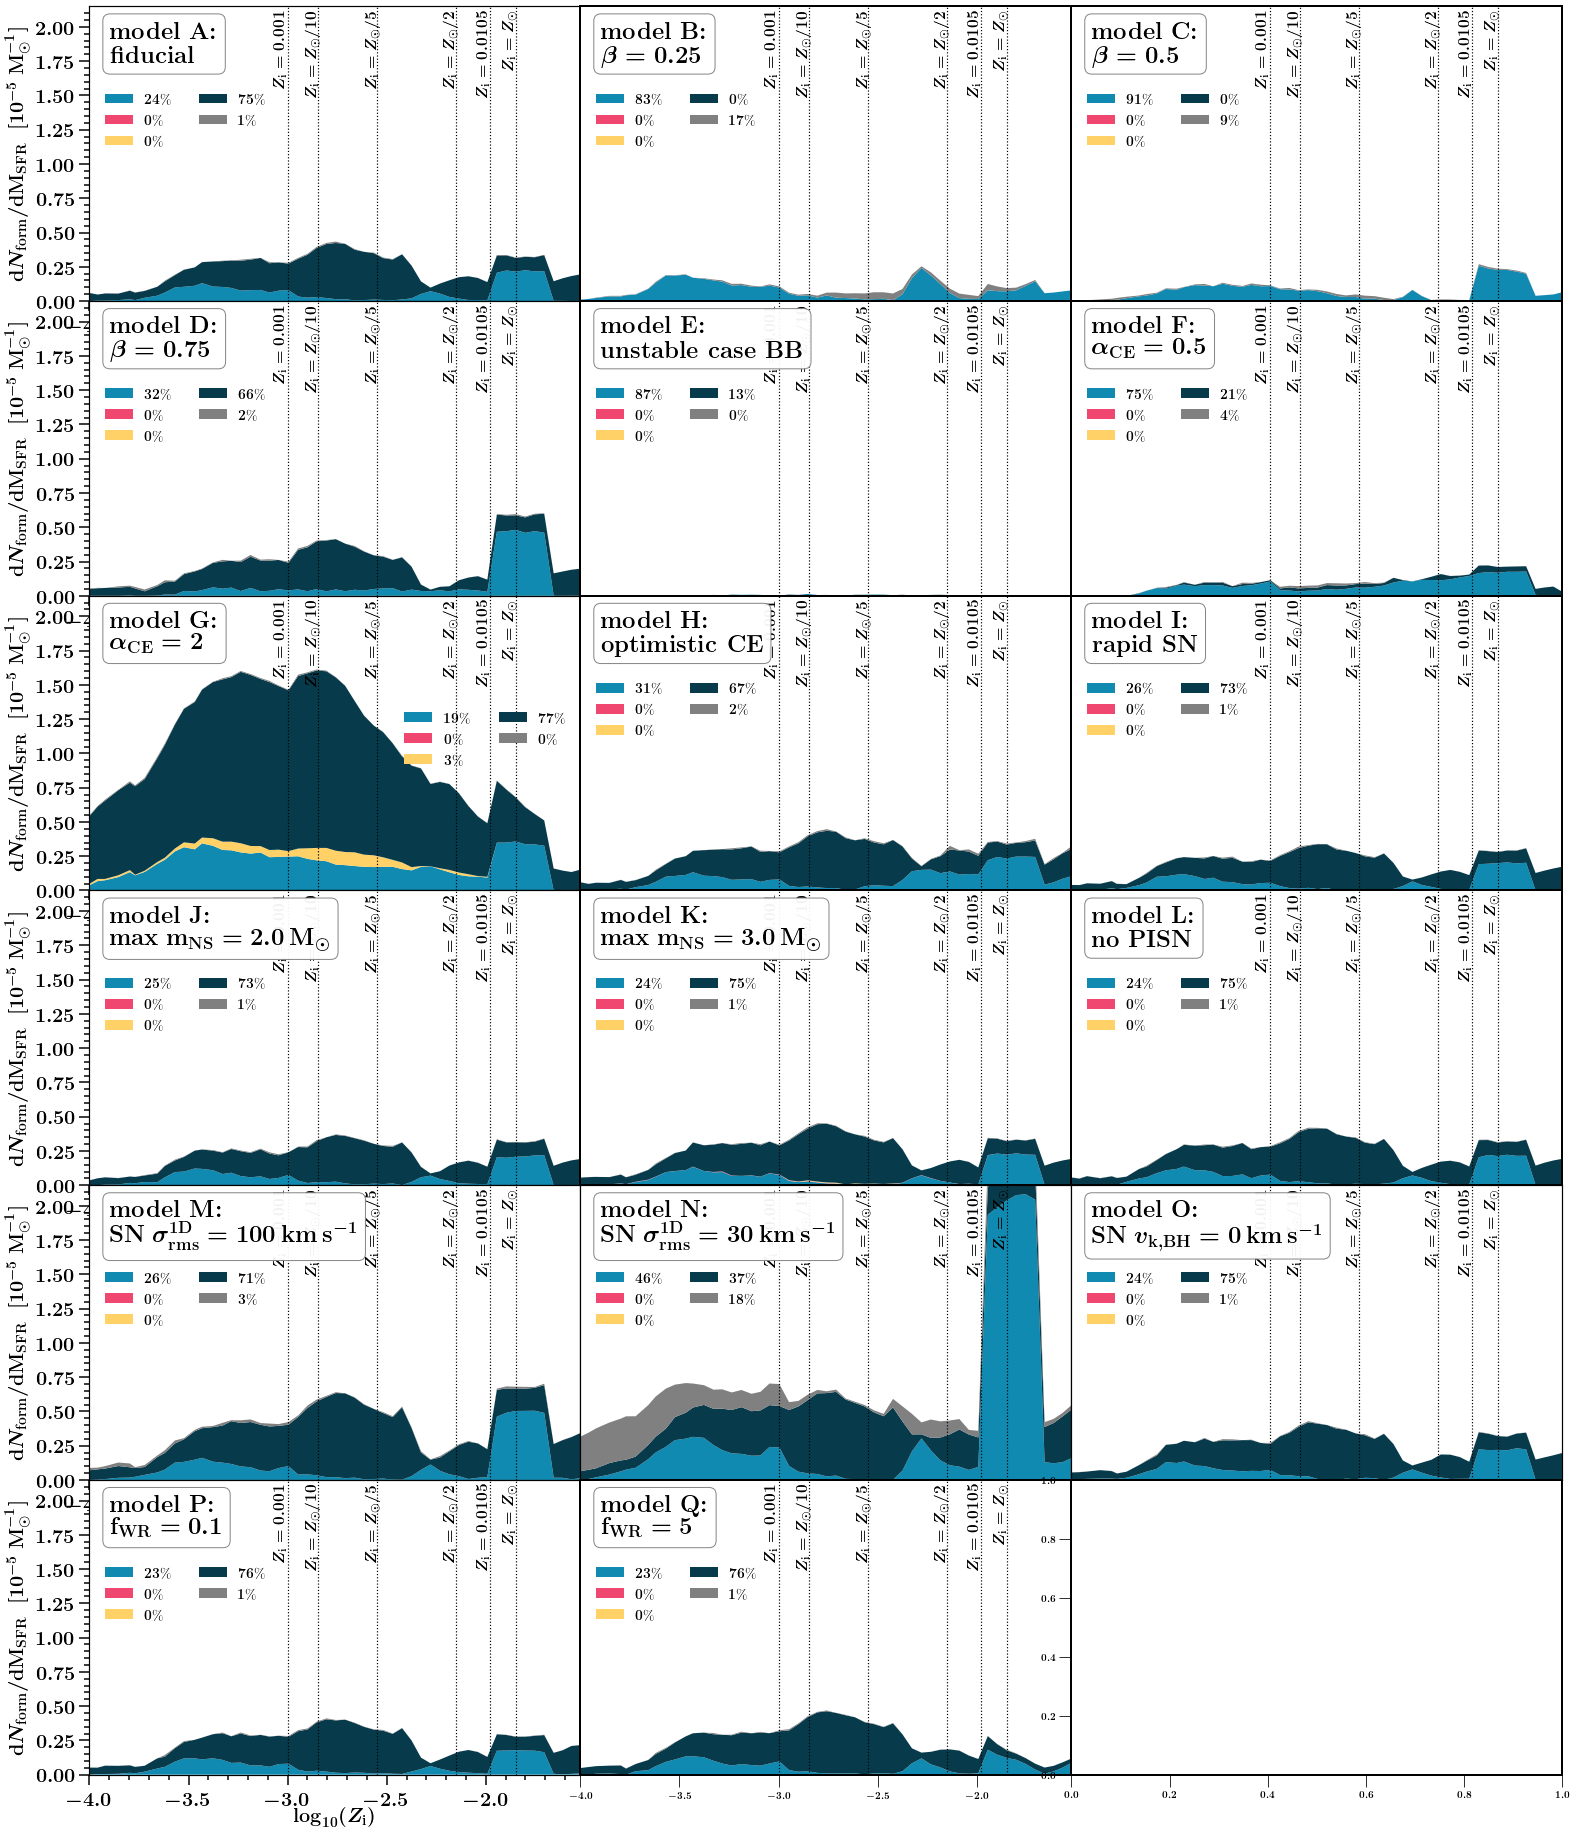

In [61]:
csvPath ='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_1/' 
plotGridFormationRatePerMetallicity(DCOtype = 'BNS',Ylim = 2.15, csvPath=csvPath)

